In [1]:
import os

CUDA_VISIBLE = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_VISIBLE
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'


import torch
from torch import nn
from torch.nn.functional import elu
from transformers.models.bart.modeling_bart import BartAttention
from model import LinearAttention
import torch.utils.benchmark as benchmark

In [2]:
bsz = 32
emb_dim = 768 # the same emb dim used in bart
heads_qty = 12 # the same amount of heads in bart base
seq_len = sorted(list(range(64, 2049, 64)), reverse=True)
device = torch.device('cuda' if torch.cuda.is_available() else cpu)

In [3]:
def inference_benchmark(model, vec):
    with torch.no_grad():
        output, _, _ = model(vec)
        torch.cuda.synchronize()
        
def training_benchmark(model, vec):
    output, _, _ = model(vec)
    loss = output.mean()
    loss.backward()
    torch.cuda.synchronize()

In [4]:
def run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=False, linear=False):
    
    if linear:
        model = LinearAttention(emb_dim, heads_qty)
    else:
        model = BartAttention(emb_dim, heads_qty)
    if train:
        for param in model.parameters():
            param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = False
            
    model.to(device)
    
    results = []
    for s in seq_len:
        x = torch.rand((bsz, s, emb_dim), device=device)
        if train:
            t = benchmark.Timer(
                stmt='training_benchmark(model, vec)',
                setup='from __main__ import training_benchmark',
                globals={'model': model, 'vec': x})
        else:
            t = benchmark.Timer(
                stmt='inference_benchmark(model, vec)',
                setup='from __main__ import inference_benchmark',
                globals={'model': model, 'vec': x})
        results.append(t.timeit(30).mean * 1000)
        del x
        torch.cuda.empty_cache()
        
    del model
    torch.cuda.empty_cache()
    
    return results
            

In [5]:
l_t = run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=True, linear=True)
l_i = run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=False, linear=True)
v_i = run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=False, linear=False)
v_t = run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=True, linear=False)

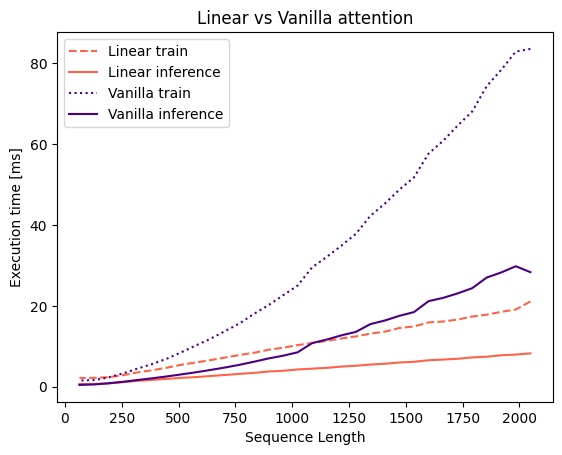

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_title("Linear vs Vanilla attention")
ax.set_xlabel("Sequence Length")
ax.set_ylabel("Execution time [ms]")

ax.plot(seq_len, l_t, label="Linear train", color="tomato", linestyle="dashed")
ax.plot(seq_len, l_i, label="Linear inference", color="tomato")
ax.plot(seq_len, v_t, label="Vanilla train", color="indigo", linestyle="dotted")
ax.plot(seq_len, v_i, label="Vanilla inference", color="indigo")


ax.legend(loc="upper left")


fig.savefig("benchmark.png")

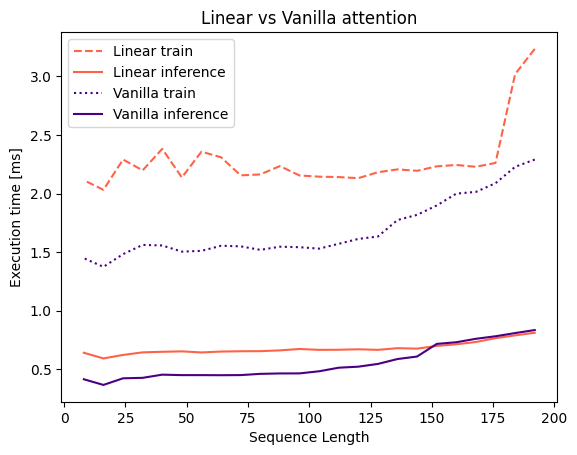

In [8]:
seq_len = sorted(list(range(8, 193, 8)), reverse=True)
l_t = run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=True, linear=True)
l_i = run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=False, linear=True)
v_i = run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=False, linear=False)
v_t = run_benchmark(device, bsz, emb_dim, heads_qty, seq_len, train=True, linear=False)

fig, ax = plt.subplots()

ax.set_title("Linear vs Vanilla attention")
ax.set_xlabel("Sequence Length")
ax.set_ylabel("Execution time [ms]")

ax.plot(seq_len, l_t, label="Linear train", color="tomato", linestyle="dashed")
ax.plot(seq_len, l_i, label="Linear inference", color="tomato")
ax.plot(seq_len, v_t, label="Vanilla train", color="indigo", linestyle="dotted")
ax.plot(seq_len, v_i, label="Vanilla inference", color="indigo")


ax.legend(loc="upper left")


fig.savefig("benchmark_small_seq_len.png")